In [1]:
import subprocess
import os
import sys

import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
from utils import *

In [2]:
sys.path.insert(1, '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/')
# sys.path.insert(1, '/extra/stefan/utils/scrnaseq_utils/')
from scrnaseq_util_functions import *

In [3]:
data_path = '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'


h5_files = {}
for path, subdirs, files in os.walk(data_path):
    for name in files:
        if '.h5' in name: h5_files[name[:-3]] = os.path.join(path, name)
del h5_files['exampledataset']
del h5_files['NormanWeissman2019_raw']
del h5_files['PapalexiSatija2021_eccite_arrayed_protein']
del h5_files['PapalexiSatija2021_eccite_protein']
del h5_files['FrangiehIzar2021_protein']
print(len(h5_files))
list(h5_files.keys())

39


['PapalexiSatija2021_eccite_arrayed_RNA',
 'PapalexiSatija2021_eccite_RNA',
 'TianKampmann2021_CRISPRa',
 'TianKampmann2021_CRISPRi',
 'XieHon2017',
 'AissaBenevolenskaya2021',
 'McFarlandTshemiak2020_all_expts_combined',
 'GasperiniShendure2019_lowMOI',
 'GasperiniShendure2019_atscale',
 'GasperiniShendure2019_highMOI',
 'ZhaoSims2021',
 'DixitRegev2016',
 'DatlingerBock2017',
 'DatlingerBock2021',
 'FrangiehIzar2021_RNA',
 'WeinrebKlein2020',
 'ShifrutMarson2018',
 'ReplogleWeissman2022_K562_essential.h',
 'ReplogleWeissman2022_K562_gwps.h',
 'ReplogleWeissman2022_rpe1',
 'ChangYe2021',
 'gene_scores',
 'peak_bc',
 'ChromVar',
 'LSI_embedding',
 'markerpeak_target',
 'SchiebingerLander2019_GSE115943',
 'SchiebingerLander2019_GSE106340',
 'NormanWeissman2019_filtered',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen',
 'AdamsonWeissman2016_GSM2406677_10X005',
 'AdamsonWeissman2016_GSM2406681_10X010',
 'AdamsonWei

In [4]:
SDIR = "/fast/scratch/users/peidlis_c/perturbation_resource_paper/"
adata = sc.read(SDIR+'tmp_data_' + 'NormanWeissman2019_filtered' + '.h5')

# sc.pp.filter_cells(adata, min_counts=1000)
# sc.pp.normalize_per_cell(adata)
# sc.pp.filter_genes(adata, min_cells=50)
# sc.pp.log1p(adata)

# # high class imbalance
# adata = equal_subsampling(adata, 'perturbation', N_min=100, remove_low=True)

# # select HVGs
# n_var_max = 1000  # max total features to select
# sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3')
# sc.pp.pca(adata, use_highly_variable=True)

In [5]:
adata.obs.perturbation.value_counts()

AHR               54
POU3F2_CBFA2T3    54
MAPK1             54
MAPK1_IKZF3       54
MAPK1_PRTG        54
                  ..
FOSB_PTPN12       54
FOSB_UBASH3B      54
FOXA1             54
FOXA1_FOXF1       54
control           54
Name: perturbation, Length: 237, dtype: int64

# Train a single classifier for all perturbations

In [11]:
conf_mat, classes = simple_classifier_confusion(adata, 'X_pca', 'perturbation', test_size_fraction=0.2, n_nodes=0, method='SVC')

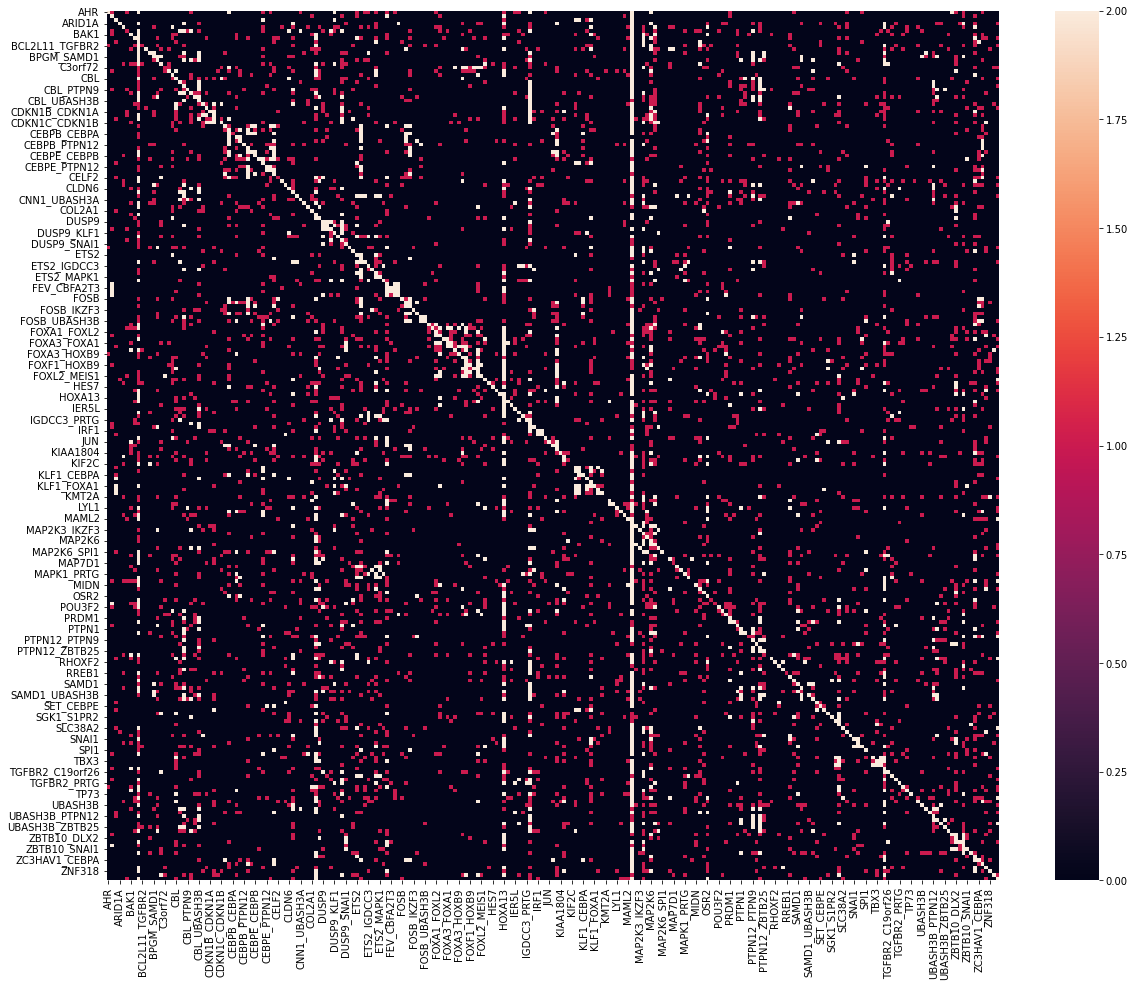

In [12]:
pl.figure(figsize=[20,16])
tab = pd.DataFrame(conf_mat, index=classes, columns=classes)
sns.heatmap(tab, robust=True)
pl.show()

In [7]:
# tab=pd.read_csv('./analysis_screens/tables/simple_confusion_'+'NormanWeissman2019_filtered'+'_tables.csv', index_col=0)

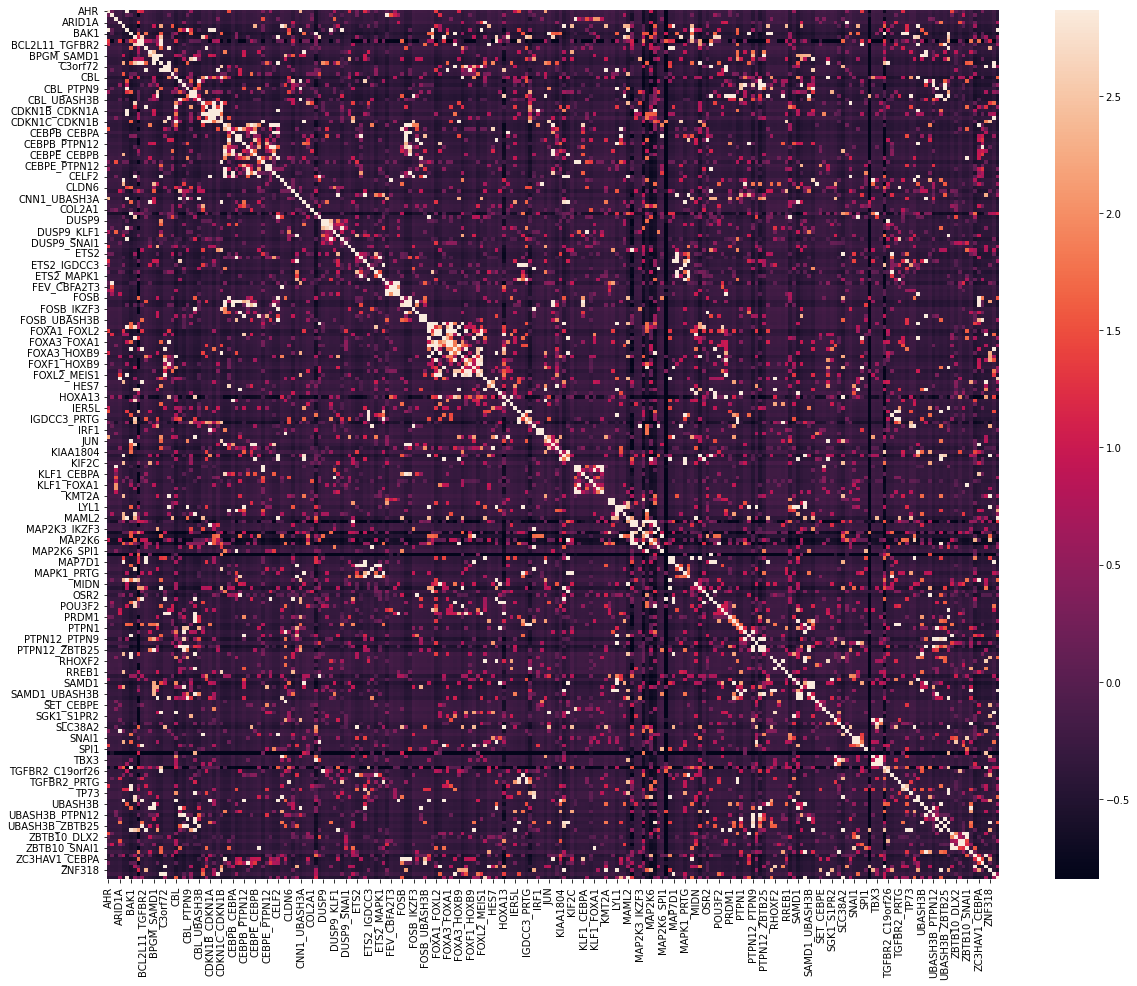

In [16]:
pl.figure(figsize=[20,16])
ntab = pd.DataFrame(zscore(tab, axis=0), tab.index, tab.columns)
ntab = ntab.fillna(np.nanmin(ntab))
ntab = ntab+ntab.T
# ntab = cluster_matrix(ntab, 'both')
sns.heatmap(ntab, robust=True)
pl.show()

# Train one classifier per perturbation

## Leave out one perturbation, then project onto others (looc)

100%|██████████| 97/97 [06:36<00:00,  4.09s/it]


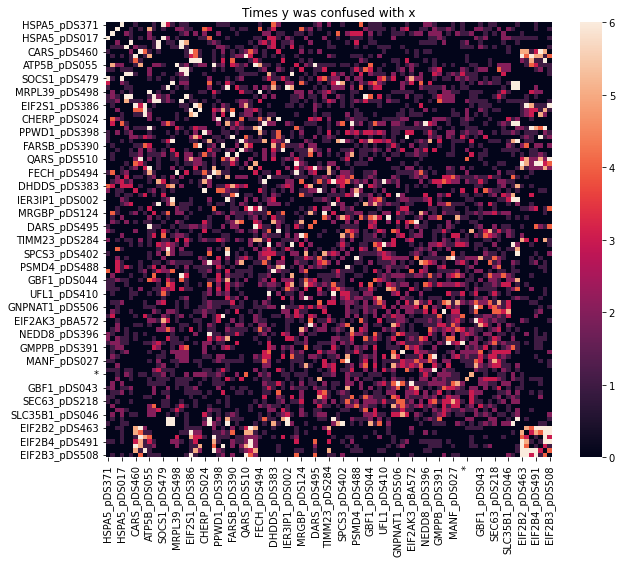

In [6]:
tab = leave_one_out_classification(adata, 'X_pca', 'perturbation', method='SVC', plot=True, plot_each=False)

## Only control and one selected perturbation (labooc)

This is very strongly affected by class imbalance.

In [6]:
overall_confusion = leave_all_but_one_out_classification(adata, 'X_pca', 'perturbation', method='SVC', plot=True, show=True, test_size=0.25, control='control')

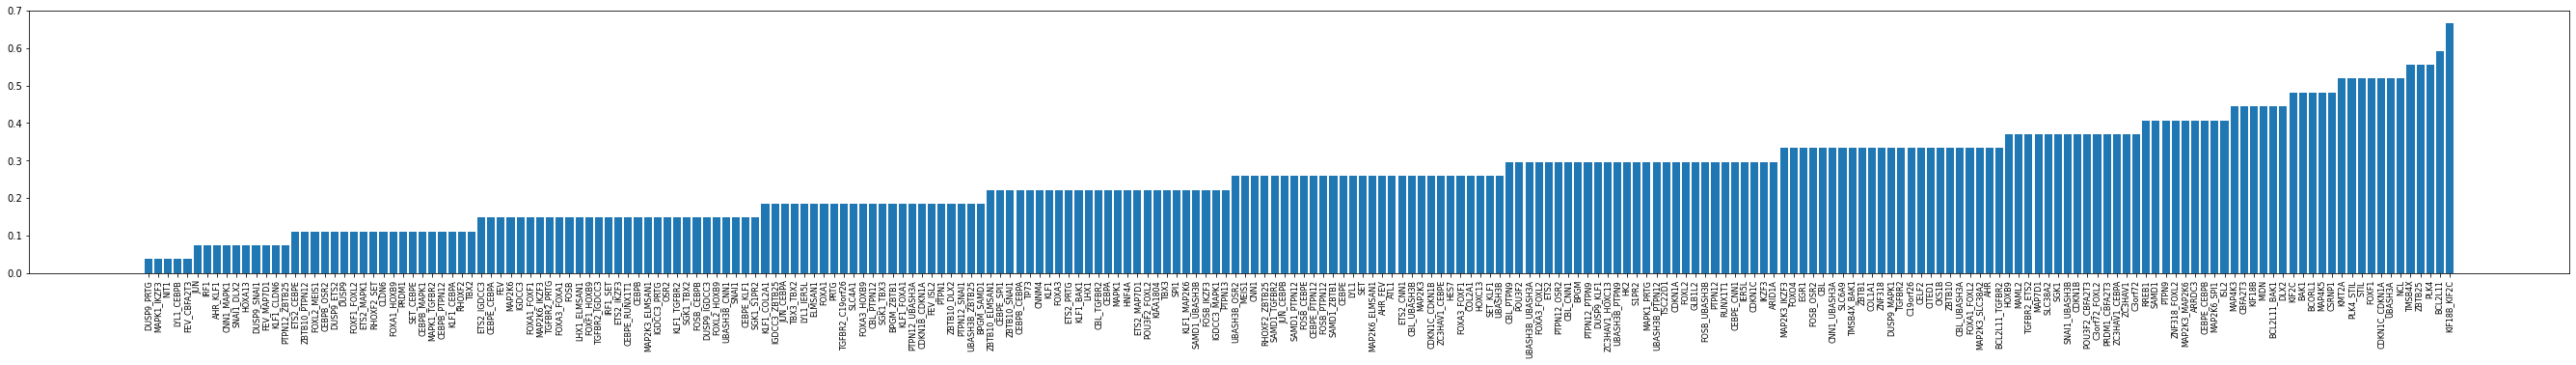

In [8]:
N = len(overall_confusion)
pl.figure(figsize=[N/5, 5])
x = np.arange(N)
pl.bar(x, overall_confusion)
pl.xticks(x, overall_confusion.index, rotation=90, fontsize=8)
pl.show()

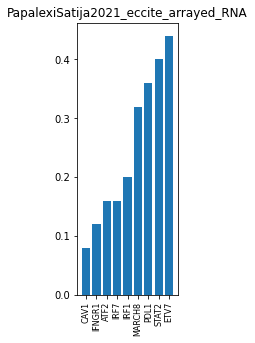

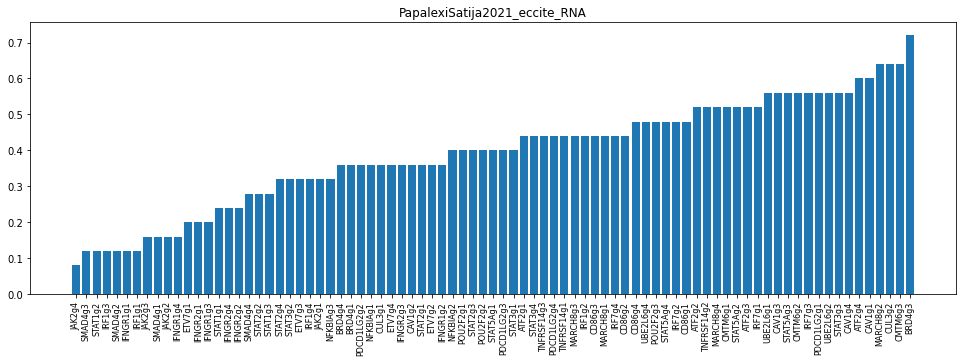

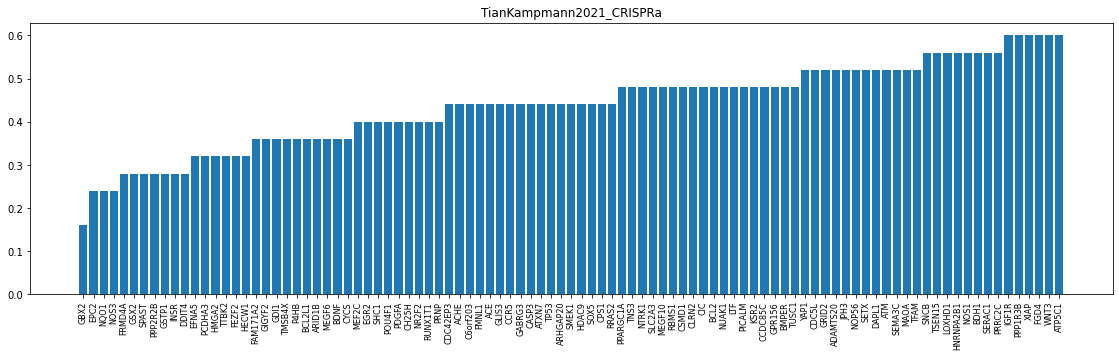

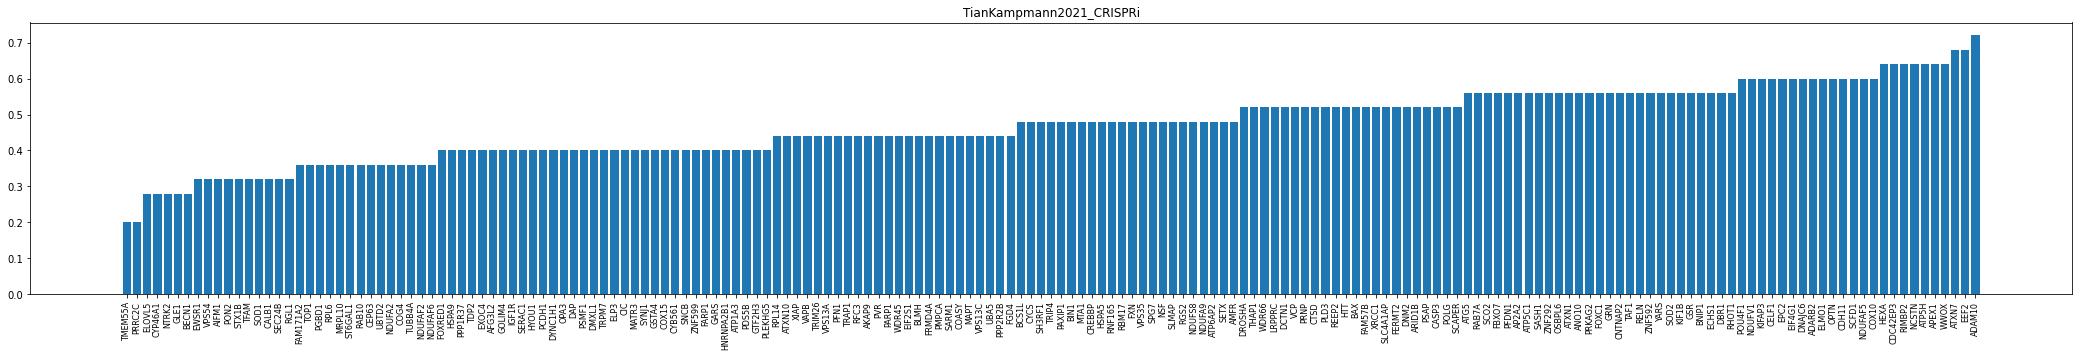

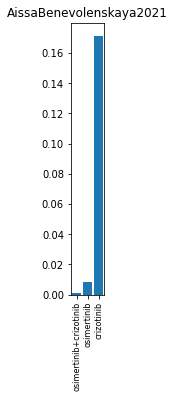

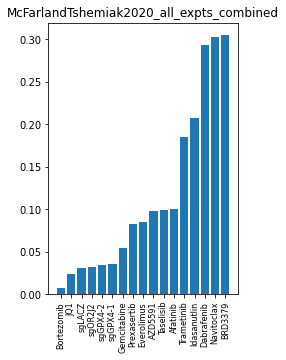

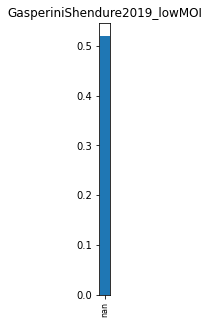

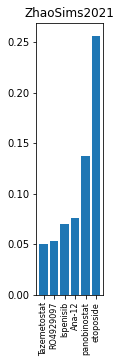

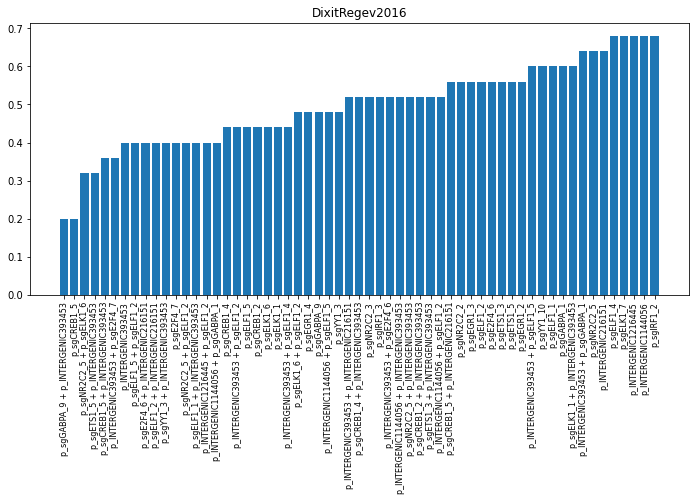

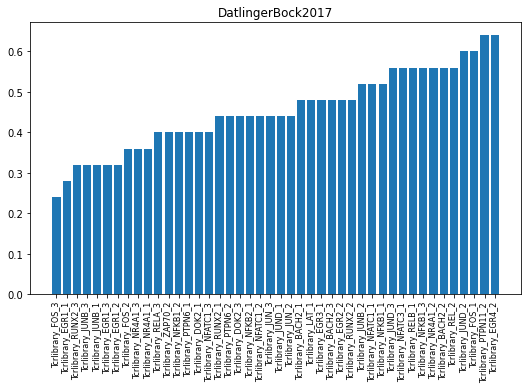

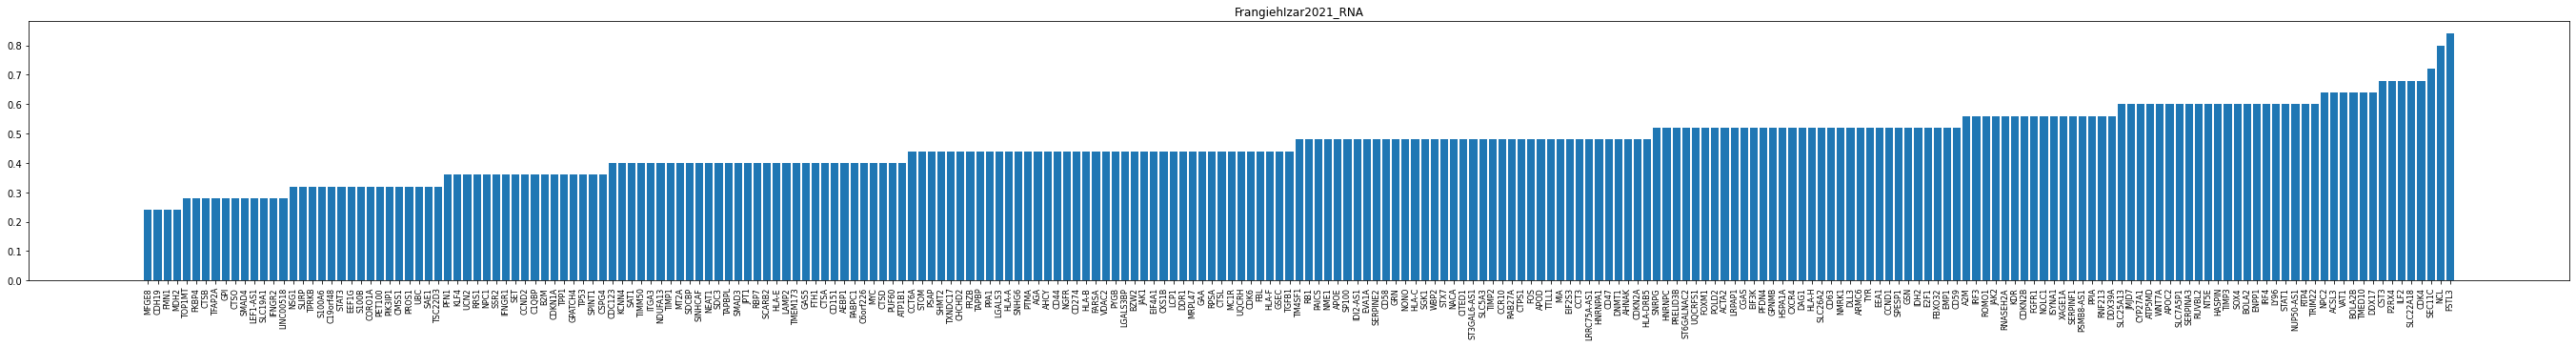

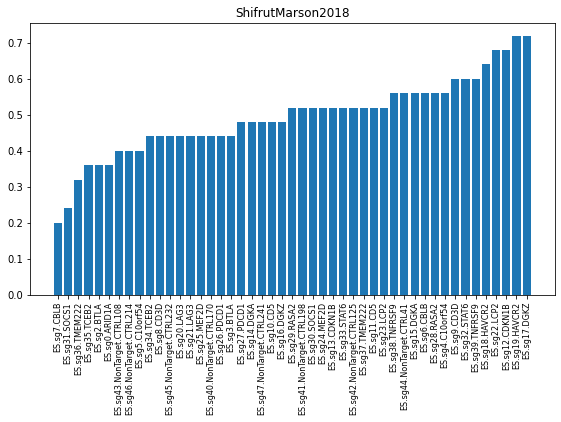

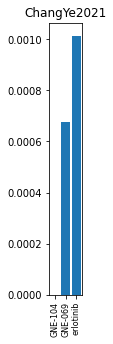

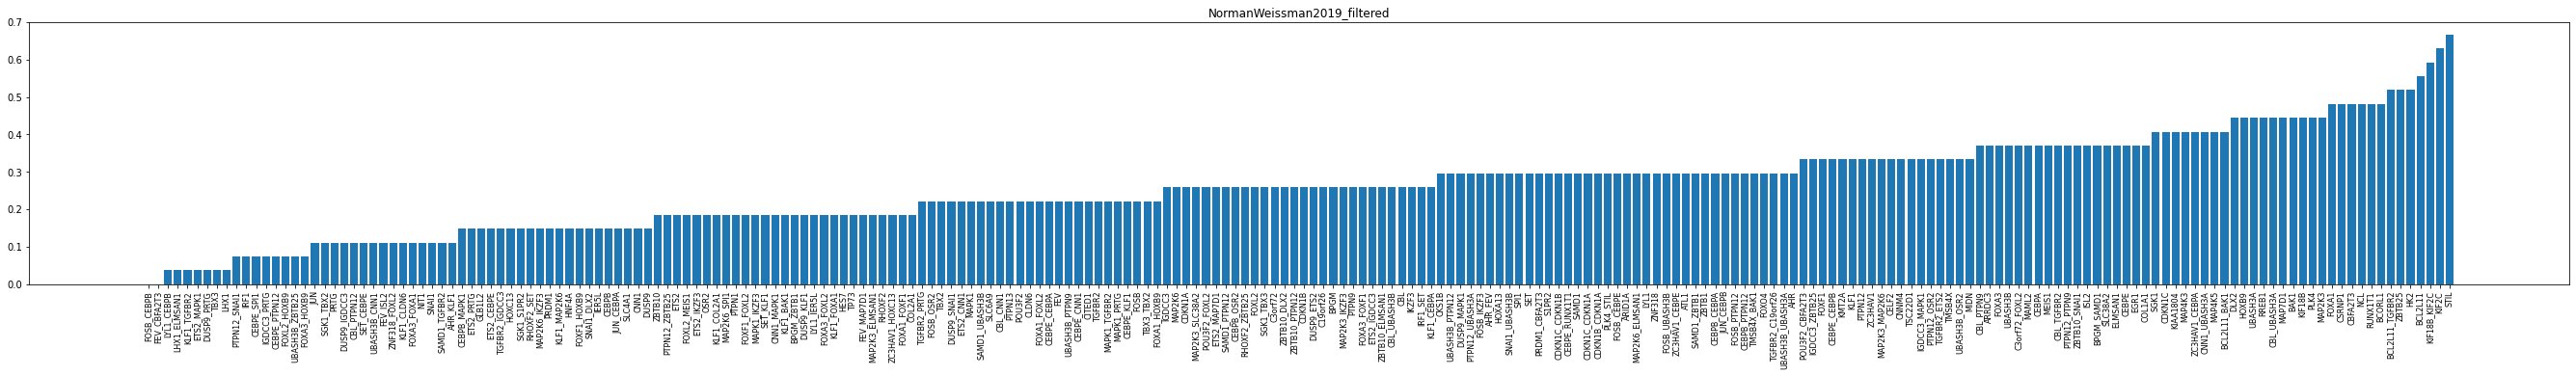

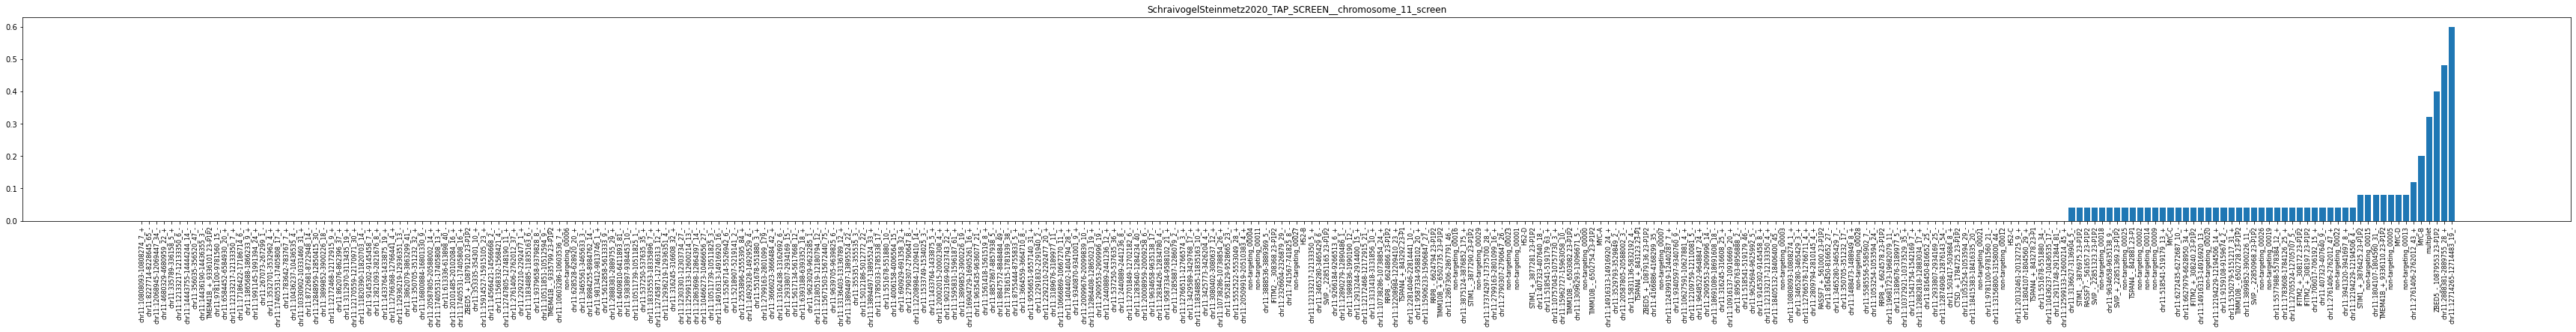

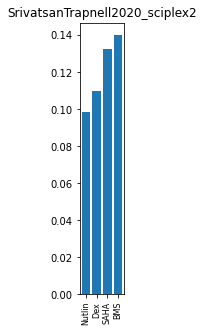

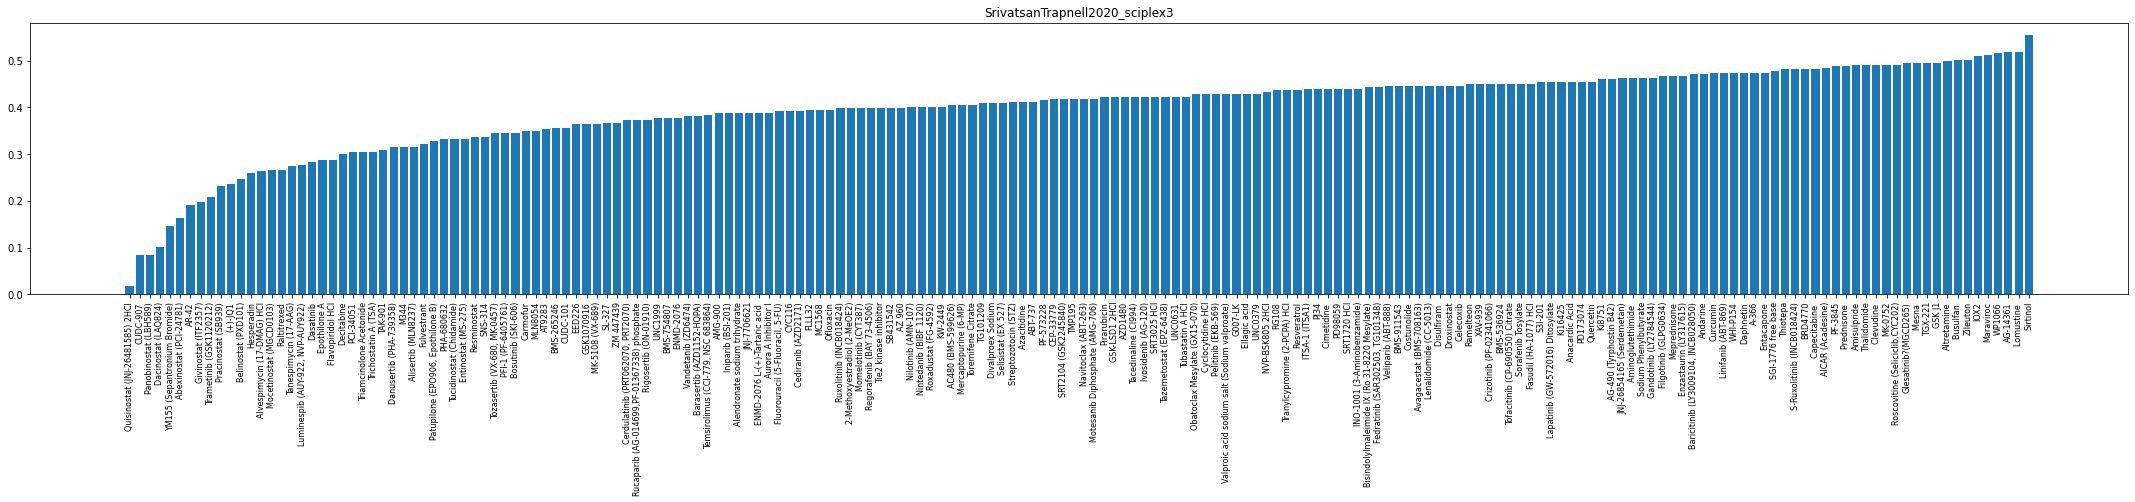

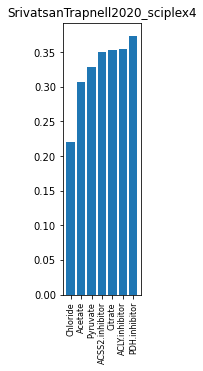

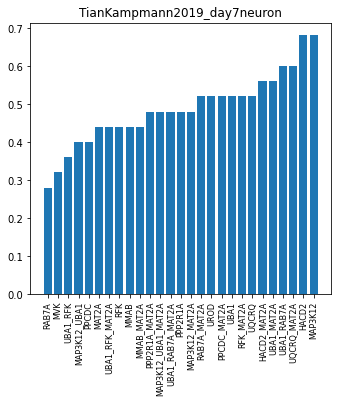

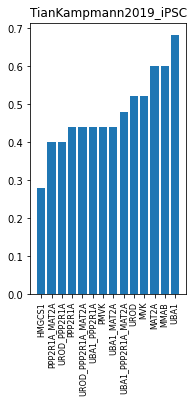

In [15]:
writer = pd.ExcelWriter("labooc.xlsx")
for key in h5_files.keys():
    try:
        adata = sc.read(f'{SDIR}tmp_data_{key}.h5')
        overall_confusion = leave_all_but_one_out_classification(adata, 'X_pca', 'perturbation', method='SVC', plot=True, show=True, test_size=0.25, control='control')
    except:
        continue
    
    N = len(overall_confusion)
    pl.figure(figsize=[N/5, 5])
    x = np.arange(N)
    pl.bar(x, overall_confusion)
    pl.xticks(x, overall_confusion.index, rotation=90, fontsize=8)
    pl.title(key)
    pl.show()
    overall_confusion.to_excel(writer, sheet_name=key[:31])
writer.close()

### old

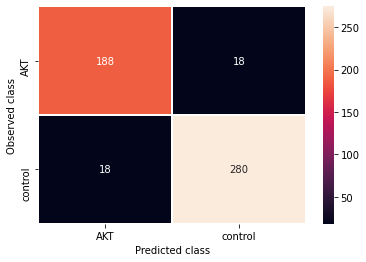

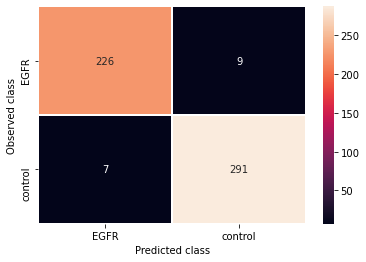

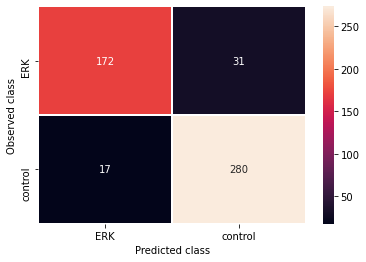

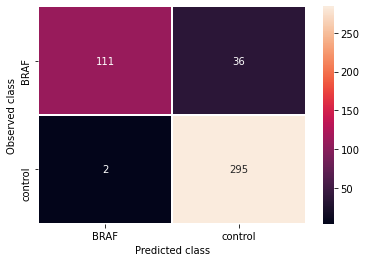

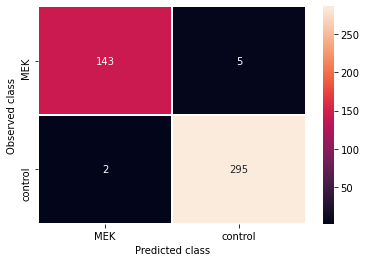

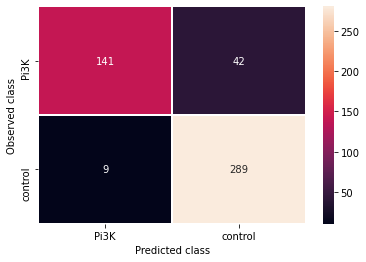

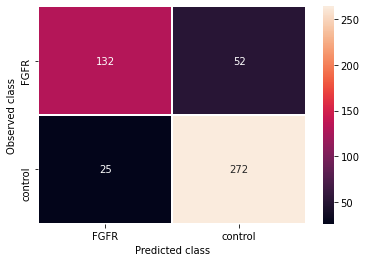

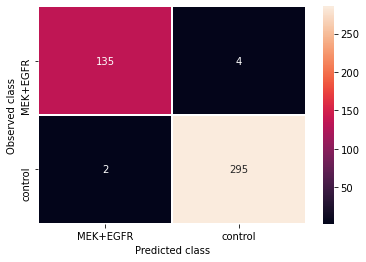

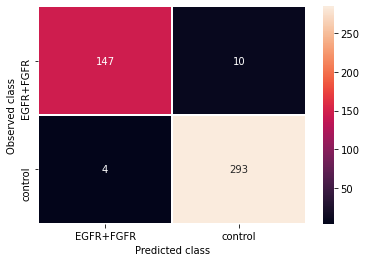

In [275]:
for selected_class in pd.unique(adata.obs.perturbation)[:10]:
    if selected_class == 'control':
        continue
    mask = (adata.obs.perturbation == selected_class) | (adata.obs.perturbation == 'control')

    # Define and split training and test data
    from sklearn.model_selection import train_test_split
    X = adata.obsm['X_pca'][mask]  # data
    y = list(adata.obs.perturbation[mask])  # labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)  # stratify=labels makes sure same label ratio in splits
    
    # Feature scaling
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # select and train classifier (here KNN classifier)
    from sklearn.neighbors import KNeighborsClassifier
    classifier = KNeighborsClassifier(n_neighbors=5)
    classifier.fit(X_train, y_train);
    
    # predict labels of 2 classes
    y_test_pred = classifier.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_test_pred)
    
    tab = pd.DataFrame(conf_mat, index=classifier.classes_, columns=classifier.classes_)
    tab, idx = reorder_matrix(tab)
    ax = sns.heatmap(tab, linewidths=.5, annot=True, fmt="d", robust=True)
    pl.ylabel('Observed class')
    pl.xlabel('Predicted class')
    pl.show()

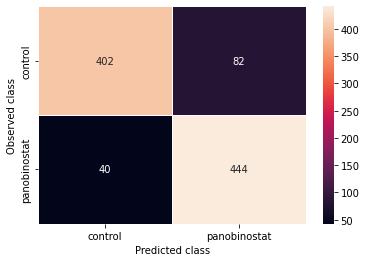

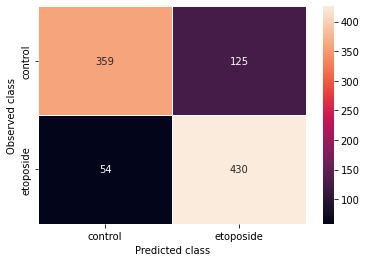

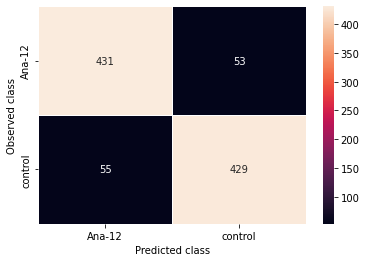

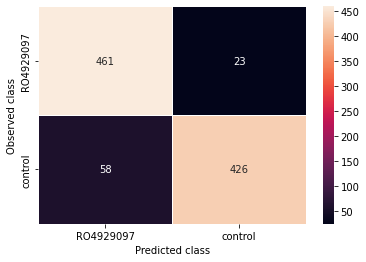

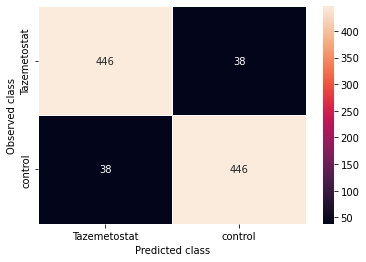

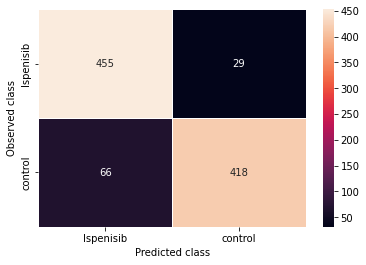

In [43]:
for selected_class in pd.unique(adata.obs.perturbation)[:10]:
    if selected_class == 'control':
        continue
    mask = (adata.obs.perturbation == selected_class) | (adata.obs.perturbation == 'control')

    # Define and split training and test data
    from sklearn.model_selection import train_test_split
    X = adata.obsm['X_pca'][mask]  # data
    y = list(adata.obs.perturbation[mask])  # labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)  # stratify=labels makes sure same label ratio in splits
    
    # Feature scaling
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # select and train classifier (here KNN classifier)
    from sklearn.neighbors import KNeighborsClassifier
    classifier = KNeighborsClassifier(n_neighbors=5)
    classifier.fit(X_train, y_train);
    
    # predict labels of 2 classes
    y_test_pred = classifier.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_test_pred)
    
    tab = pd.DataFrame(conf_mat, index=classifier.classes_, columns=classifier.classes_)
    ax = sns.heatmap(tab, linewidths=.5, annot=True, fmt="d", robust=True)
    pl.ylabel('Observed class')
    pl.xlabel('Predicted class')
    pl.show()

# Notes

- [x] do 1:1 method only on test set, not on training
- [ ] how many PCs is good? Compare!
- [ ] alternative to PCA: use union of perturbation-wise top HVGs. Otherwise we get bias into feature selection...
- [x] subsample to fight class imbalance
- [ ] alternatively try cost sensitive methods
- [ ] get error bars / robust score by multiple iterations (stochasticity through subsampling or train/test splitting)
- [ ] better define these three methods, write text, get notation and wording right. Compare (advantages and disadvantages of each method)